# 2nd Assignment
## Exercise 2
2023/5/27

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
from functools import reduce
from abc import abstractmethod
from operator import mul
from typing import Union, Iterable, Optional
from abc import ABC, abstractmethod
from torch.nn import Module, Parameter


## **Methods**

In [ ]:
def raster_plot(spikes):
    x=[]
    y=[]
    for i,neuron in enumerate(spikes):
                id=f'{i}'
                for l in range(len(neuron)):
                    if neuron[l]:
                        x.append(l)
                        y.append(id)

    figure = plt.figure(figsize=(15, 7))
    ax1 = figure.add_subplot(111)
    ax1.scatter(x, y,marker='s',s=1)
    ax1.set_ylabel("neuron ID")
    ax1.set_xlabel("time (mS)")
    ax1.set_title('raster plot',fontsize=16)

    plt.show()

In [ ]:
def plot_current(data):
    fig = plt.figure(figsize=(20,5))
    plt.plot([i for i in range(len(data))], data)
    plt.xlabel("time (mS)")
    plt.ylabel("current (pA)")
    plt.grid()
    plt.title("current diagram")
    plt.show()

## **Define Models**

In [ ]:
class NeuralPopulation(torch.nn.Module):

    def __init__(
        self,
        n: Optional[int] = None,
        shape: Optional[Iterable[int]] = None,
        spike_trace: bool = True,
        additive_spike_trace: bool = True,
        tau_s: Union[float, torch.Tensor] = 15.,
        trace_scale: Union[float, torch.Tensor] = 1.,
        sum_input: bool = False,
        is_inhibitory: bool = False,
        learning: bool = True,
        dt: Union[float, torch.Tensor] = 0.1,
        R: Union[float, torch.Tensor] = 20.0,
        **kwargs
    ) -> None:

        super().__init__()

        assert (n is not None or shape is not None), "Must provide either number of neurons or shape of layer"

        if n is None:
            self.n = reduce(mul, shape) # Number of neurons product of shape
        else:
            self.n = n # Number of neurons

        if shape is None:
            self.shape = [self.n] # Shape is equal to the of the layer
        else:
            self.shape = shape # Shape is passed in as an argument

        assert self.n == reduce(mul, self.shape), "Number of neurons and shape do not match"

        self.spike_trace = spike_trace
        self.additive_spike_trace = additive_spike_trace
        self.sum_input = sum_input # Whether to sum all inputs

        if self.spike_trace:
            self.register_buffer("traces", torch.zeros(*self.shape))
            self.register_buffer("tau_s", torch.tensor(tau_s))

            if self.additive_spike_trace:
                self.register_buffer("trace_scale", torch.tensor(trace_scale))

            self.register_buffer("trace_decay", torch.empty_like(self.tau_s))

        self.is_inhibitory = is_inhibitory
        self.learning = learning

        self.register_buffer("s", torch.ByteTensor())
        self.s = torch.zeros(*self.shape, device=self.s.device, dtype=torch.bool)
        self.register_buffer("R", torch.tensor(R))

        if self.sum_input:
            self.register_buffer("summed", torch.FloatTensor()) # Inputs summation

        self.dt = dt

    @abstractmethod
    def forward(self, x: torch.Tensor) -> None:

        if self.spike_trace:
            self.traces *= self.trace_decay

            if self.additive_spike_trace:
                self.traces += self.trace_scale * self.s.float()
            else:
                self.traces.masked_fill_(self.s, 1)

        if self.sum_input:
            self.summed += x.float()

    @abstractmethod
    def compute_potential(self) -> None:
        pass

    @abstractmethod
    def compute_spike(self) -> None:
        pass

    @abstractmethod
    def refractory_and_reset(self) -> None:
        pass

    @abstractmethod
    def compute_decay(self) -> None:
        self.dt = torch.tensor(self.dt)

        if self.spike_trace:
            self.trace_decay = torch.exp(-self.dt/self.tau_s)  # Spike trace decay (per timestep).

    def reset_state_variables(self) -> None:
        self.s.zero_()

        if self.spike_trace:
            self.traces.zero_()

        if self.sum_input:
            self.summed.zero_()  # Inputs summation.

    def train(self, mode: bool = True) -> "NeuralPopulation":
        self.learning = mode
        return super().train(mode)



class LIFPopulation(NeuralPopulation):

    def __init__(
        self,
        n: Optional[int] = None,
        shape: Optional[Iterable[int]] = None,
        spike_trace: bool = True,
        additive_spike_trace: bool = False,
        tau_s: Union[float, torch.Tensor] = 10.,
        threshold: Union[float, torch.Tensor] = -52.,
        rest_pot: Union[float, torch.Tensor] = -62.,
        reset_pot: Union[float, torch.Tensor] = -62.,
        refrac_length: Union[float, torch.Tensor] = 5,
        dt: float = 0.1,
        lower_bound: float = None,
        sum_input: bool = False,
        trace_scale: Union[float, torch.Tensor] = 1.,
        R: Union[float, torch.Tensor] = 20.,
        is_inhibitory: bool = False,
        learning: bool = True,
        **kwargs
    ) -> None:

        super().__init__(
            n=n,
            shape=shape,
            spike_trace=spike_trace,
            additive_spike_trace=additive_spike_trace,
            tau_s=tau_s,
            sum_input=sum_input,
            trace_scale=trace_scale,
            is_inhibitory=is_inhibitory,
            learning=learning,
            dt=dt,
            R=R
        )

        self.register_buffer("rest_pot", torch.tensor(rest_pot, dtype=torch.float))
        self.register_buffer("reset_pot", torch.tensor(reset_pot, dtype=torch.float))
        self.register_buffer("pot_threshold", torch.tensor(threshold, dtype=torch.float))
        self.register_buffer("refrac_length", torch.tensor(refrac_length))
        self.register_buffer("v", torch.FloatTensor()) # Neuron's potential
        self.register_buffer("refrac_count", torch.FloatTensor()) # Refractor counter
        self.v = self.rest_pot * torch.ones(*self.shape, device=self.v.device)
        self.refrac_count = torch.zeros_like(self.v, device=self.refrac_count.device)
        self.register_buffer("tau_s", torch.tensor(tau_s, dtype=torch.float))  # Time constant of neuron voltage decay.
        self.compute_decay() # Compute decays and set time steps
        self.reset_state_variables()
        self.lower_bound = lower_bound

    def forward(self, x: torch.Tensor) -> None:
        self.compute_potential(x)
        self.compute_spike()
        self.refractory_and_reset()
        if self.lower_bound is not None:
            self.v.masked_fill_(self.lower_bound > self.v, self.lower_bound)

        super().forward(x)

    def compute_potential(self, x: torch.Tensor) -> None:
        self.v += (( - (self.v - self.rest_pot) + self.R * x) * self.dt / self.tau_s) * (self.refrac_count <= 0).float()

    def compute_spike(self) -> None:
        self.s = self.v >= self.pot_threshold

    @abstractmethod
    def refractory_and_reset(self) -> None:
        super().refractory_and_reset()
        self.refrac_count -= self.dt
        self.refrac_count.masked_fill_(self.s, self.refrac_length)
        self.v.masked_fill_(self.s, self.reset_pot)

    @abstractmethod
    def compute_decay(self) -> None:
        super().compute_decay()

    def reset_state_variables(self) -> None:
        super().reset_state_variables()
        self.v.fill_(self.rest_pot) # Reset neuron voltages
        self.refrac_count.zero_() # Refractory period reset


In [ ]:
class AbstractConnection(ABC, torch.nn.Module):

    def __init__(
        self,
        pre: NeuralPopulation,
        post: NeuralPopulation,
        w: torch.Tensor,
        d: torch.Tensor,
        d_min: float = 0.0,
        d_max: float = 100.0,
        mask: torch.ByteTensor = True,
        **kwargs
    ) -> None:
        super().__init__()

        assert isinstance(pre, NeuralPopulation), \
            "Pre is not a NeuralPopulation instance"
        assert isinstance(post, NeuralPopulation), \
            "Post is not a NeuralPopulation instance"

        self.pre = pre
        self.post = post

        self.w = w

        self.w_min = kwargs.get('w_min', torch.zeros(pre.n, post.n))
        self.w_max = kwargs.get('w_max', torch.ones(pre.n, post.n))
        self.norm = kwargs.get('norm', None)

        self.d_min = d_min
        self.d_max = d_max

        self.delay_mem = torch.Tensor([])
        self.w_mem = torch.Tensor([])

    @abstractmethod
    def compute(self, s: torch.Tensor) -> None:
        pass

    @abstractmethod
    def update(self, **kwargs) -> None:
        pass

    @abstractmethod
    def reset_state_variables(self) -> None:
        pass



class Connection(AbstractConnection):
    def __init__(
        self,
        pre: NeuralPopulation,
        post: NeuralPopulation,
        w: torch.Tensor = None,
        d: torch.Tensor = None,
        d_min: float = 0.0,
        d_max: float = 100.0,
        mask: torch.ByteTensor = True,
        **kwargs
    ) -> None:
        super().__init__(
            pre = pre,
            post = post,
            w = w,
            d = d,
            d_min = d_min,
            d_max = d_max,
            mask = mask,
            **kwargs
        )
        if w is None:
            if (self.w_min == float('-inf')) or (self.w_max == float('inf')):
                w = torch.clamp(torch.rand(pre.n, post.n), self.w_min, self.w_max)
            else:
                w = self.w_min + torch.rand(pre.n, post.n) * (self.w_max - self.w_min)
        else:
            if (self.w_min != float('-inf')) or (self.w_max != float('inf')):
                w = torch.clamp(torch.as_tensor(w), self.w_min, self.w_max)

        if d is None:
            d = self.d_min + torch.rand(pre.n, post.n) * (self.d_max - self.d_min)
        else:
            if (self.d_min != 0.0) or (self.d_max != 100.0):
                d = torch.clamp(torch.as_tensor(d), self.d_min, self.d_max)

        self.w = Parameter(w, requires_grad=False)
        self.d = Parameter(d, requires_grad=False)

        b = kwargs.get("b", None)
        if b is not None:
            print(b)
            self.b = Parameter(b, requires_grad=False)
        else:
            self.b = None

    def reset_state_variables(self) -> None:
        super().reset_state_variables()

    def normalize(self) -> None:
        if self.norm is not None:
            w_abs_sum = self.w.abs().sum(0).unsqueeze(0)
            w_abs_sum[w_abs_sum == 0] = 1.0
            self.w *= self.norm / w_abs_sum

    def update(self, **kwargs) -> None:
        super().update(**kwargs)

    def compute(self, s: torch.Tensor) -> None:
        spike_trace = torch.flatten(s)
        if self.b is None:
            post = spike_trace.view(1, -1).float() @ self.w
        else:
            post = spike_trace.view(1, -1).float() @ self.w + self.b
        return post.view(*self.post.shape)

## **Create populations**

In [ ]:
n_neurons = 80
refrac_len=0.00001
delta_t = 0.001
Rs = torch.tensor([10 + np.random.rand() * 2 for i in range(n_neurons)])
u_rests = torch.tensor([random.randint(-60, -55) for i in range(n_neurons)])
thresholds = torch.tensor([random.randint(-55, -50) for i in range(n_neurons)])
u_resets = torch.tensor([random.randint(-65, -61) for i in range(n_neurons)])

ex_population1 = LIFPopulation(n=n_neurons,
                               dt=delta_t,
                               refrac_length=refrac_len,
                               R=Rs,
                               u_rest=u_rests,
                               threshold=thresholds,
                               u_reset=u_resets)

ex_population2 = LIFPopulation(n=n_neurons,
                               dt=delta_t,
                               refrac_length=refrac_len,
                               R=Rs,
                               u_rest=u_rests,
                               threshold=thresholds,
                               u_reset=u_resets)

in_population = LIFPopulation(n=n_neurons,
                              is_inhibitory=True,
                              dt=delta_t,
                              refrac_length=refrac_len,
                              R=Rs,
                              u_rest=u_rests,
                              threshold=thresholds,
                              u_reset=u_resets)


/tmp/ipykernel_32/2335322354.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("R", torch.tensor(R))
/tmp/ipykernel_32/2335322354.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("pot_threshold", torch.tensor(threshold, dtype=torch.float))


In [ ]:
ex1_to_ex1 = Connection(pre=ex_population1, post=ex_population1, w_min=50, w_max=250)
ex2_to_ex2 = Connection(pre=ex_population2, post=ex_population2, w_min=50, w_max=250)
in_to_in = Connection(pre=in_population, post=in_population, w_min=50, w_max=450)

ex1_to_ex2 = Connection(pre=ex_population1, post=ex_population2, w_min=50, w_max=250)
ex2_to_ex1 = Connection(pre=ex_population2, post=ex_population1, w=ex1_to_ex2.w, w_min=50, w_max=250)

ex1_to_in = Connection(pre=ex_population1, post=in_population, w_min=50, w_max=450)
in_to_ex1 = Connection(pre=in_population, post=ex_population1, w_min=50, w_max=450)

ex2_to_in = Connection(pre=ex_population2, post=in_population, w=ex1_to_in.w, w_min=50, w_max=450)
in_to_ex2 = Connection(pre=in_population, post=ex_population2, w=in_to_ex1.w, w_min=50, w_max=450)

## **Create currents**

In [ ]:
duration = 250
noise_dt = 50
noise_start = 40
const_curr = 1000
noise1 = 10000
noise2 = 15000


noisy_curr1 = [const_curr] * duration
noisy_curr2 = [const_curr] * duration

for i in range(noise_start, duration, noise_dt):
    noisy_curr1[i] = noise1
    noisy_curr2[i] = noise2

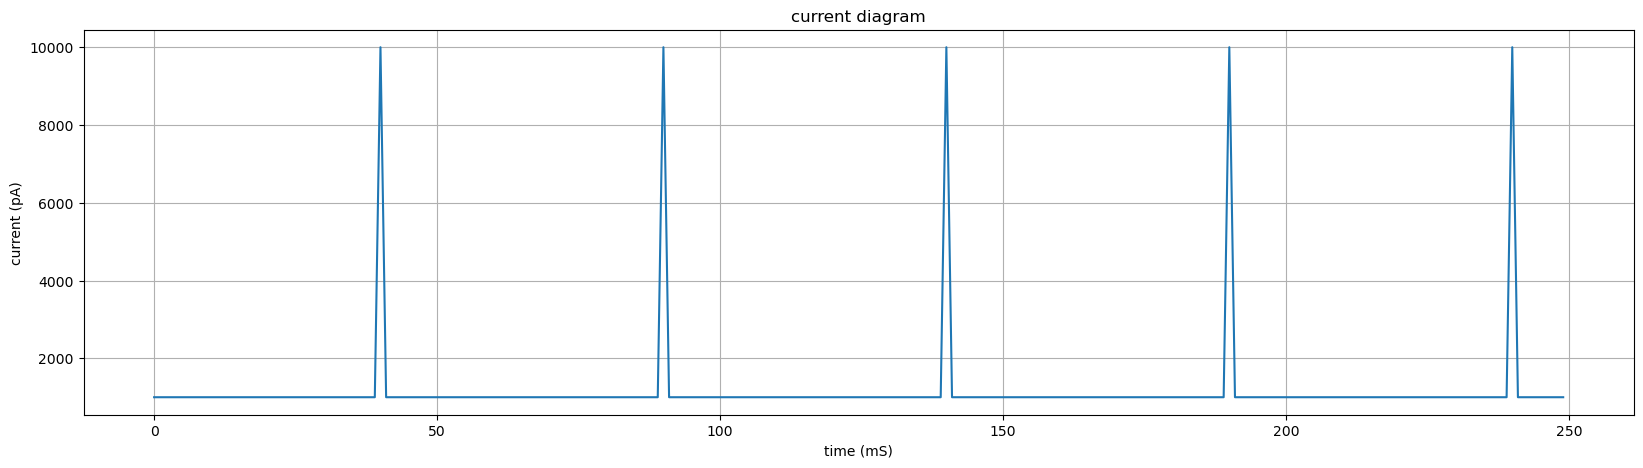

In [ ]:
plot_current(noisy_curr1)

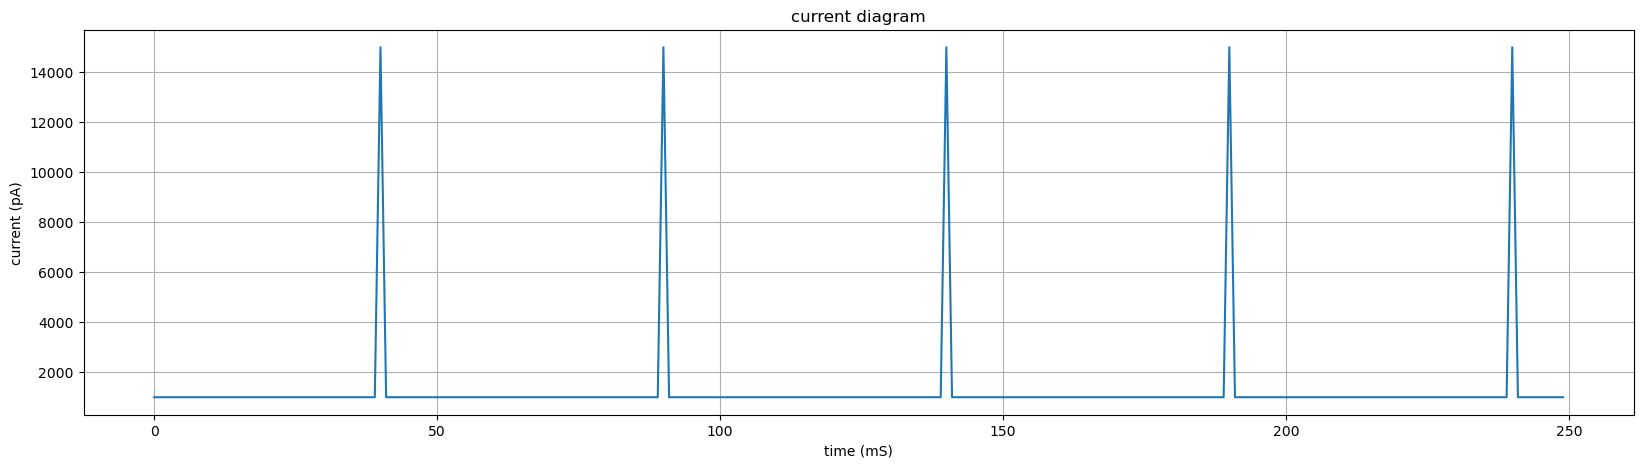

In [ ]:
plot_current(noisy_curr2)

## **Compare outputs**

In [ ]:
ex1_spikes = []
ex2_spikes = []
in_spikes = []
for i in range(duration):
    ex_population1.forward(torch.tensor([noisy_curr1[i]]*n_neurons) +
                           torch.matmul(ex_population1.s.float(), ex1_to_ex1.w) +
                           torch.matmul(ex_population2.s.float(), ex2_to_ex1.w) +
                           torch.matmul(in_population.s.float(), -in_to_ex1.w)
                          )
    ex_population2.forward(torch.tensor([noisy_curr2[i]]*n_neurons) +
                           torch.matmul(ex_population2.s.float(), ex2_to_ex2.w) +
                           torch.matmul(ex_population1.s.float(), ex1_to_ex2.w) +
                           torch.matmul(in_population.s.float(), -in_to_ex2.w)
                          )
    in_population.forward(torch.matmul(in_population.s.float(), -in_to_in.w) +
                           torch.matmul(ex_population1.s.float(), ex1_to_in.w) +
                           torch.matmul(ex_population2.s.float(), ex2_to_in.w)
                          )
    ex1_spikes.append(ex_population1.s.tolist())
    ex2_spikes.append(ex_population2.s.tolist())
    in_spikes.append(in_population.s.tolist())



In [ ]:
ex1_spikes = torch.tensor(ex1_spikes).T.tolist()
ex2_spikes = torch.tensor(ex2_spikes).T.tolist()
in_spikes = torch.tensor(in_spikes).T.tolist()

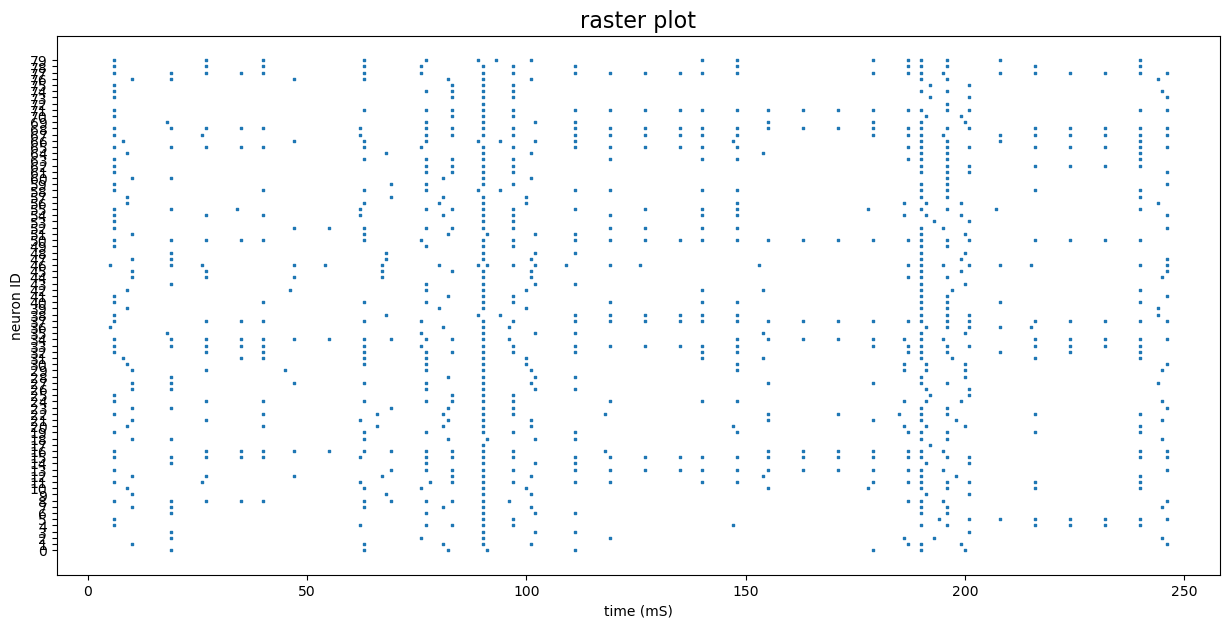

In [ ]:
raster_plot(ex1_spikes)

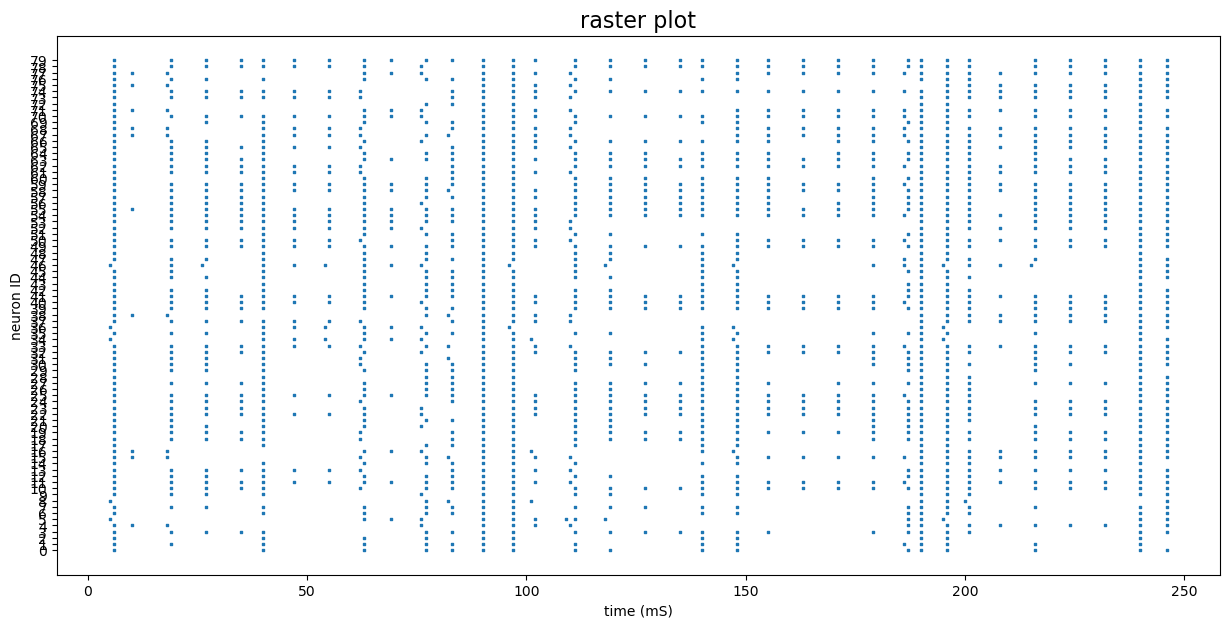

In [ ]:
raster_plot(ex2_spikes)

In [ ]:
raster_plot(in_spikes)

In [ ]:
sum1 = 0
sum2 = 0
for i in range(n_neurons):
    sum1+=sum(ex1_spikes[i])
    sum2+=sum(ex2_spikes[i])

sum1, sum2

(976, 1828)

In [ ]:
halves_diff1 = 0
halves_diff2 = 0
for i in range(n_neurons):
    halves_diff1 += sum(ex1_spikes[i][125:]) - sum(ex1_spikes[i][:124])
    halves_diff2 += sum(ex2_spikes[i][125:]) - sum(ex2_spikes[i][:124])

halves_diff1, halves_diff2

(-68, 24)